In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly

In [2]:
### only run once! sets up working directory to be /quality_issue_predictor
import os
os.chdir(os.getcwd()[:-34] + r'\quality_issue_predictor') 

In [46]:
archived_df = pd.read_csv('./clean_data/archived_so.csv')
archived_df = archived_df.drop(columns = 'Unnamed: 0')
ncs_df = pd.read_csv('./clean_data/NCs.csv')

In [7]:
import qa_productivity_tool.quality_report as qr

In [10]:
product_parcer = qr.Quality_Report(None)

In [12]:
ncs_df['Product Family']= list(map(product_parcer.return_product_family,ncs_df['Product']))

In [29]:
ncs_df['Value Stream'] = list(map(product_parcer.return_value_stream,ncs_df['Product']))
cff_ncs = ncs_df.copy()
cff_ncs = cff_ncs[cff_ncs['Value Stream']=='Containers']
# remove planned deviations
cff_ncs = cff_ncs[cff_ncs['Initial Failure Mode']!='PR-Planned Deviation']
# only include molding NCs
molding_ncs = ['CFF-V-Flash (Functional Area)','CFF-D-Molding 1','CFF-V-Contamination (Embedded)',
               'CFF-F-Molding 3','CFF-V-Blisters, Bubbles and Voids','CFF-V-Flash (Non-Functional Area), Gate',
               'CFF-V-Short', 'CFF-V-SHORT','CFF-V-Warping, Deformation and Pulling','CFF-V-Broken, Cracking, and Crazing', 
               'CFF-V-Packaging 2','CFF-V-Molding 6','CFF-D-Molding 3','Out of Spec Visual Inspection (Visual Defect)',
               'CFF-F-Molding 8', 'CFF-V- Blisters, Bubbles and Voids','CFF-V-Contamination','Manual- Lid Fit failed',
               'CFF-F-Molding 2', 'CFF-F-Molding 7']
cff_mold_ncs = pd.DataFrame()
for ifm,frame in cff_ncs.groupby(by = 'Initial Failure Mode'):
    if ifm in molding_ncs:
        frame['NC Category'] = 'molding'
        cff_mold_ncs = pd.concat([cff_mold_ncs,frame])
cff_mold_ncs = cff_mold_ncs.reset_index(drop = True)
        
               
               

In [54]:
len(cff_mold_ncs)

209

In [47]:
archived_df['Value Stream'] = list(map(product_parcer.return_value_stream,archived_df['Product']))
archived_df = archived_df[archived_df['Value Stream'] ==  'Containers']

In [48]:
%%time
#remove formula sheets (probably no value)
archived_df = archived_df[(archived_df['Component'].str.contains('FS')==False) & (archived_df['Component'].str.contains('DC')==False)]\
                .reset_index(drop=True)

df = pd.DataFrame()
for lot, frame in archived_df.groupby('Lot Number'):
    df.loc[lot,frame['Product'].unique()[0]] = 1
    for i,comp in enumerate(frame['Component']):
        frame = frame.reset_index(drop = True)
        if frame.loc[i,'BOM qty']>0:
            df.loc[lot,comp] = frame.loc[i,'BOM qty']
df =df.fillna(0).reset_index().rename(columns = {'index':'Lot Number'})
print(df.shape)

(2366, 457)
Wall time: 39.4 s


In [51]:
%%time
for i, lot in enumerate(df['Lot Number']):
    if lot in cff_mold_ncs['Lot Number'].unique():
        df.loc[i,'NC'] = 1
    else:
        df.loc[i,'NC'] = 0

Wall time: 1.99 s


In [53]:
sum(df.NC)

77.0

In [75]:
NC_lots_not_found = pd.DataFrame()
for lot,frame in cff_mold_ncs.groupby(by = 'Lot Number'):
    if lot not in df['Lot Number'].unique():
        NC_lots_not_found = pd.concat([NC_lots_not_found,frame])

In [76]:
NC_lots_not_found

,Unnamed: 0,NC Number,Created Date,NC Type,Discovery/Plant Area,Discovery/Plant Area Name,Product,Initial Failure Mode,Lot Number,Closed Date,NC TAT,Product Family,Value Stream,NC Category
140,126,NC-IL081-10317,2019-03-23 10:27:26.033,Internal,C18,Press 18-IL081,WP8506,CFF-V-SHORT,18B51563,2019-08-21 19:45:44.190,151.0,SS,Containers,molding
141,127,NC-IL081-10317,2019-03-23 10:27:26.033,Internal,C18,Press 18-IL081,WP8506,CFF-V-SHORT,18B51563,2019-08-21 19:45:44.190,151.0,SS,Containers,molding
193,4395,NC-IL081-34424,2021-09-07 17:34:01.973,Internal,C81,Press 81-IL081,89651,CFF-V-Short,21F10563,NaN,NaN,G2,Containers,molding
194,4396,NC-IL081-34424,2021-09-07 17:34:01.973,Internal,C81,Press 81-IL081,89651,CFF-V-Short,21F10563,NaN,NaN,G2,Containers,molding
195,4397,NC-IL081-34424,2021-09-07 17:34:01.973,Internal,C81,Press 81-IL081,89651,CFF-V-Short,21F10563,NaN,NaN,G2,Containers,molding
196,4398,NC-IL081-34424,2021-09-07 17:34:01.973,Internal,C81,Press 81-IL081,89651,CFF-V-Short,21F10563,NaN,NaN,G2,Containers,molding
197,4399,NC-IL081-34424,2021-09-07 17:34:01.973,Internal,C81,Press 81-IL081,89651,CFF-V-Short,21F10563,NaN,NaN,G2,Containers,molding


In [56]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

In [57]:
sum(y)/len(X)

0.03254437869822485

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [60]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_recall_curve

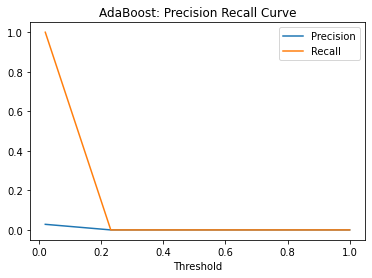

Wall time: 1.32 s


In [72]:
%%time
rng = np.random.RandomState(1)
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

ada_reg.fit(X_train,y_train)
y_1 = ada_reg.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test,y_1)
plt.plot(thresholds,precision[:-1],label = 'Precision')
plt.plot(thresholds,recall[:-1],label = 'Recall')
plt.title('AdaBoost: Precision Recall Curve')
plt.xlabel('Threshold')
plt.legend()
plt.show()

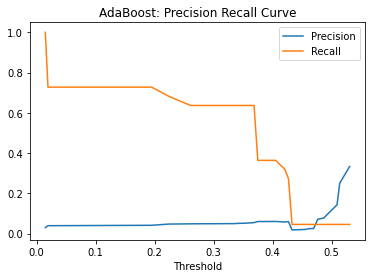

<AxesSubplot:>

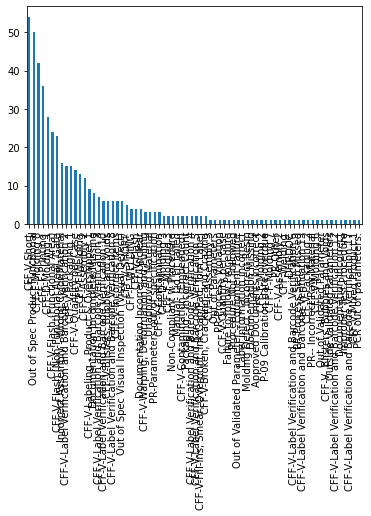

In [22]:
pd.value_counts(cff_ncs['Initial Failure Mode']).plot.bar()